In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass

keras.backend.clear_session()



ImportError: cannot import name 'to_categorical' from 'keras.utils' (/Users/stephanbremser/neuefische/alzheimer-classification/.venv/lib/python3.9/site-packages/keras/utils/__init__.py)

In [2]:
# DataGeneratro from web. Speeds up generation of tensor dataset by feeding batches to the dataset load

class DataGenerator(keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return batch_x, batch_y

  def __call__(self):
    self.i = 0
    return self


### Load Train Set
<i>-deconstruct the set and oversample-<i>

In [3]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                        

# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))


Found 4094 files belonging to 4 classes.


In [4]:
# seperation of validation set
# !!! these sets are not shuffled !!!

train_big = train_ds
X1_train_big = []
y1_train_big = []
X2_train_big = []
y2_train_big = []
X3_train_big = []
y3_train_big = []
X4_train_big = []
y4_train_big = []

for img, label in train_ds.unbatch():
    if label.numpy()[0] == 1:
        X1_train_big.append(img.numpy())
        y1_train_big.append(label.numpy())

    if label.numpy()[1] == 1:
        X2_train_big.append(img.numpy())
        y2_train_big.append(label.numpy())

    if label.numpy()[2] == 1:
        X3_train_big.append(img.numpy())
        y3_train_big.append(label.numpy())

    if label.numpy()[3] == 1:
        X4_train_big.append(img.numpy())
        y4_train_big.append(label.numpy())        




In [5]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_train_big = np.array(X1_train_big)
y1_train_big = np.array(y1_train_big)


In [6]:
# oversampling for class 2 (very mild)
np.random.choice(len(X2_train_big))
randomPicksIdx = [np.random.choice(len(X2_train_big)) for i in range(len(X1_train_big) - len(X2_train_big))]

for i in randomPicksIdx:
    X2_train_big.append(X2_train_big[i])
    y2_train_big.append(y2_train_big[i])

X2_train_big = np.array(X2_train_big)
y2_train_big = np.array(y2_train_big)



In [7]:
# oversampling for class 3 (mild)
np.random.choice(len(X3_train_big))
randomPicksIdx = [np.random.choice(len(X3_train_big)) for i in range(len(X1_train_big) - len(X3_train_big))]

for i in randomPicksIdx:
    X3_train_big.append(X3_train_big[i])
    y3_train_big.append(y3_train_big[i])

X3_train_big = np.array(X3_train_big)
y3_train_big = np.array(y3_train_big)


In [8]:
# oversampling for class 4 (moderate)
np.random.choice(len(X4_train_big))
randomPicksIdx = [np.random.choice(len(X4_train_big)) for i in range(len(X1_train_big) - len(X4_train_big))]

for i in randomPicksIdx:
    X4_train_big.append(X4_train_big[i])
    y4_train_big.append(y4_train_big[i])

X4_train_big = np.array(X4_train_big)
y4_train_big = np.array(y4_train_big)


In [9]:
# combine all data sets
X_train_fullset = np.concatenate((X1_train_big,X2_train_big,X3_train_big,X4_train_big), axis=0)
y_train_fullset = np.concatenate((y1_train_big,y2_train_big,y3_train_big,y4_train_big), axis=0)

In [10]:
# shuffle the whole set
X_train_temp, y_train_temp = shuffle(X_train_fullset, y_train_fullset, random_state=10)

In [11]:
# finally create tensor dataset
data_generator = DataGenerator(X_train_temp, y_train_temp, batch_size = 32)

train_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 4), dtype=tf.float32))
                                            )

### Load Validation Sets
<i>-for training-<i>

In [12]:
# load validation dataset from drive
# set for training
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1027 files belonging to 4 classes.


### Load Validation Set
<i>-deconstruct for evaluation-<i>

In [13]:
# -NOT SHUFFLED- load validation dataset from drive
# deconstructed set for evaluation
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_no_shuffle = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                       

# one hot encode the labels to fit into the cnn layers
val_no_shuffle = val_no_shuffle.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1027 files belonging to 4 classes.


In [14]:
# seperate images and labels for evaluation.
X_val = []
y_val = []

for img, label in val_no_shuffle.unbatch():
    X_val.append(img.numpy())
    y_val.append(label.numpy())
    
X_val = np.array(X_val)
y_val = np.array(y_val)

X_val, y_val = shuffle(X_val, y_val, random_state=10)

### Visualize Example Brains

f:\alzheimer-classification\envwin\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


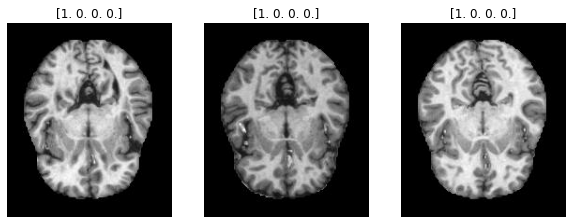

In [15]:
# # plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

### Build CNN Architecture and Model Fitting

In [16]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [17]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))


In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [19]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])


with tf.device("/gpu:0"):
    history = model.fit(x=train_fullTensor,
                        validation_data=val_ds,
                        epochs=20, 
                        shuffle=True,               #not sure if used with batched tf dataset
                        )
                        
                    

Epoch 1/20
256/256 [==============================] - 18s 48ms/step - loss: 1.2179 - precision: 0.7146 - recall: 0.1324 - auc: 0.6683 - val_loss: 0.8180 - val_precision: 0.7280 - val_recall: 0.3466 - val_auc: 0.8612
Epoch 2/20
256/256 [==============================] - 11s 42ms/step - loss: 0.6655 - precision: 0.7842 - recall: 0.5507 - auc: 0.9136 - val_loss: 0.6405 - val_precision: 0.7384 - val_recall: 0.5910 - val_auc: 0.9158
Epoch 3/20
256/256 [==============================] - 11s 42ms/step - loss: 0.4952 - precision: 0.8247 - recall: 0.7010 - auc: 0.9529 - val_loss: 0.5250 - val_precision: 0.7875 - val_recall: 0.7215 - val_auc: 0.9482
Epoch 4/20
256/256 [==============================] - 11s 44ms/step - loss: 0.3861 - precision: 0.8549 - recall: 0.7786 - auc: 0.9709 - val_loss: 0.4340 - val_precision: 0.8145 - val_recall: 0.7868 - val_auc: 0.9643
Epoch 5/20
256/256 [==============================] - 11s 42ms/step - loss: 0.3437 - precision: 0.8724 - recall: 0.7989 - auc: 0.9771 - 

### Model Evaluation

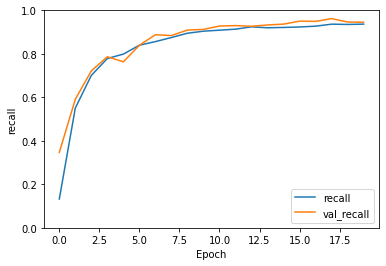

In [20]:
#print val vs accuracy

keras.backend.clear_session()
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [21]:
y_pred = model.predict(X_val, batch_size=1, verbose=1)

test_loss, test_prec, test_rec, test_auc  = model.evaluate(val_ds, verbose=2)

1027/1027 [==============================] - 2s 1ms/step
33/33 - 1s - loss: 0.1688 - precision: 0.9482 - recall: 0.9455 - auc: 0.9932 - 688ms/epoch - 21ms/step


MACRO ROC AUC SCORE: 0.9656325342865456


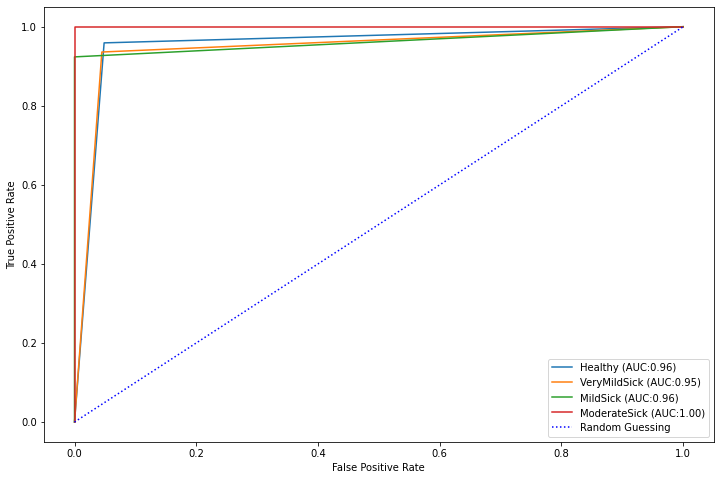

In [22]:
roc_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

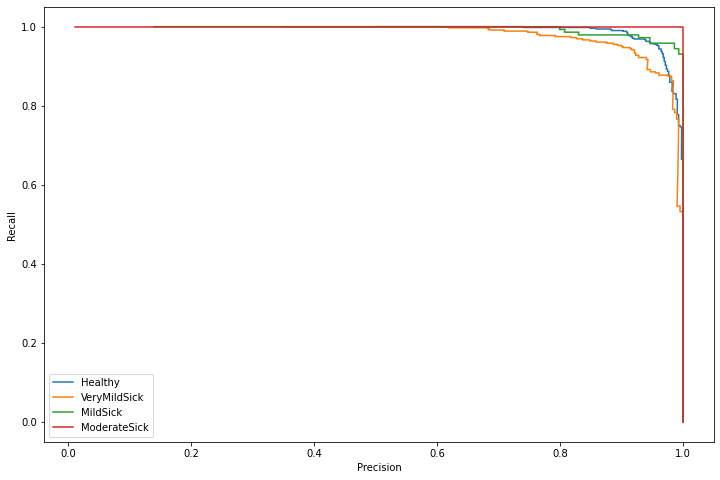

In [23]:
precision_recall_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

In [24]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")